# Multi-class (Nonlinear) SVM Example
--------------------------------

This function wll illustrate how to implement the gaussian kernel with multiple classes on the iris dataset.

Gaussian Kernel:

$$K(x_1, x_2) = e^{-\gamma \cdot (x_1 - x_2)^2}$$

X : (Sepal Length, Petal Width)

Y: (I. setosa, I. virginica, I. versicolor) (3 classes)

Basic idea: introduce an extra dimension to do one vs all classification.

The prediction of a point will be the category with the largest margin or distance to boundary.

We start by loading the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Start a computational graph session.

In [2]:
sess = tf.Session()

Now we load the iris data.

In [3]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==2]

Declare the batch size

In [4]:
batch_size = 50

Initialize placeholders and create the variables for multiclass SVM

In [5]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

Create the Gaussian Kernel

In [6]:
# Gaussian (RBF) kernel
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

Declare a function that will do reshaping and batch matrix multiplication

In [15]:
# Declare function to do reshape/batch multiplication
def reshape_matmul(mat, _size):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, _size, 1])
    return(tf.matmul(v2, v1))

Now we can compute the SVM model

In [16]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target, batch_size)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

Create the same RBF kernel for a set of prediction points (used on a grid of points at the end).

In [17]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(y_target,b), pred_kernel)
prediction = tf.argmax(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)), tf.float32))

Create the optimization and variable initializer operations.

In [18]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

We now start the training loop for the multiclass SVM

In [19]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(100):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:,rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%25==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #25
Loss = -356.52252
Step #50
Loss = -694.0222
Step #75
Loss = -1031.522
Step #100
Loss = -1369.022


For a pretty picture, to see the results, we create a fine grid of points to label/color for each class.

In [13]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Plot the results

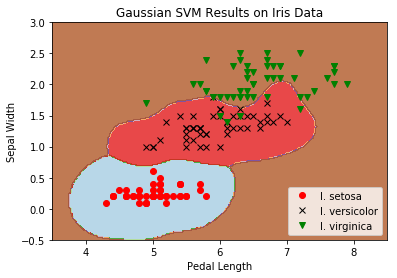

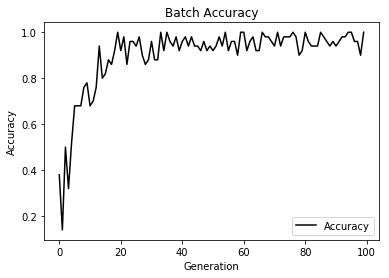

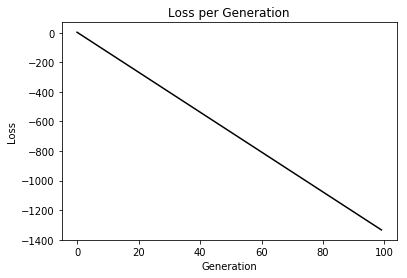

In [14]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='I. versicolor')
plt.plot(class3_x, class3_y, 'gv', label='I. virginica')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()